## Arellano (2008)

Model equations: 

\begin{eqnarray}
v^{d}&=&u\left(y^{\mathrm{def}}\right)+\beta\mathbb{E}\left[\theta v^{o}\left(0,y'\right)+\left(1-\theta\right)v^{d}\left(y'\right)\right]\\v^{c}&=&\max_{B'}\left\{ u\left(y-q\left(B',y\right)B'+B\right)+\beta\mathbb{E}\left[v^{o}\left(B',y'\right)\right]\right\} \\v^{o}\left(B,y\right)&=&\max\left\{ v^{c}\left(B,y\right),v^{d}\left(y\right)\right\} \\q\left(B',y\right)&=&\frac{1-\delta\left(B',y\right)}{1+r}\\u\left(c\right)&=&\frac{c^{1-\sigma}}{1-\sigma}
\end{eqnarray}

In [ ]:
# !pip install --upgrade pip
# # Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html --user
# !pip install --upgrade quantecon --user
# !pip install --upgrade memory_profiler --user
# !pip install --upgrade line_profiler --user

In [ ]:
!pip install quantecon

     |████████████████████████████████| 269 kB 3.2 MB/s 


### "One-loop" Algorithm

In [ ]:
# Model Parameters
β = .95282
σ = 2.
r = 0.017
θ = 0.282
ρ = 0.945
η = 0.025
y_hat = 0.969

In [ ]:
# Numerical Parameters
n_B = 200
n_y = 256
max_iter = int(1e5)
tol = 1e-12

In [ ]:
# Construct Markov chain
mc = tauchen(ρ, η, 0.0, 3, n_y)
log_y_grid, P_y = mc.state_values, mc.P
log_y_grid_onp = onp.array(log_y_grid)

# Construct grids
y_grid = jnp.exp(log_y_grid)
# B_grid = jnp.linspace(-.33, .15, n_B)
B_grid_onp = onp.linspace(-.33, .15, n_B)
zero_ind = int(jnp.searchsorted(B_grid_onp, 1e-12))
B_grid_onp[zero_ind] = 0.0
B_grid = jnp.array(B_grid_onp)

# ymean = jnp.mean(y_grid)
def_y = jnp.minimum(y_hat, y_grid)  # CHANGED HERE!
def_y_onp = onp.array(def_y)

V_d = jnp.zeros([n_y, 1])
V_c = jnp.zeros((n_y, n_B))
V = jnp.zeros((n_y, n_B))
Q = jnp.ones((n_y, n_B)) * .95

y = jnp.reshape(y_grid, [-1, 1, 1])
B = jnp.reshape(B_grid, [1, -1, 1])
B_next = jnp.reshape(B_grid, [1, 1, -1])
y_p_B = y + B

In [ ]:
# Utility function
def u(c):
    return c ** (1 - σ) / (1 - σ)


u_def_y = u(def_y)

In [ ]:
# Bellman operator
def T(V, V_c, V_d, Q):
    # Compute expectations
    EV = P_y @ V
    EV_d = P_y @ V_d

    # Compute value with default
    V_d_target = u_def_y + β * (θ * EV[:, zero_ind] + (1 - θ) * EV_d[:, 0])  # CHANGED HERE!
    V_d_target = jnp.reshape(V_d_target, [-1, 1])
    V_d = V_d_target

    # Compute value without default
    Q_rsh = jnp.reshape(Q, [n_y, 1, n_B])
    c = jnp.maximum(y_p_B - Q_rsh * B_next, 1e-16)
    EV = jnp.expand_dims(EV, axis=1)
    m = u(c) + β * EV
    idx_B = jnp.argmax(m, axis=2)
    V_c = jnp.max(m, axis=2)

    # Compute price function
    default_states = V_d > V_c
    default_prob = P_y @ default_states
    Q_new = (1 - default_prob) / (1 + r)

    # Compute value function
    V_new = jnp.maximum(V_c, V_d)

    return V_new, V_c, V_d, Q_new, idx_B

In [ ]:
%%time
_ = T(V, V_c, V_d, Q);

CPU times: user 788 ms, sys: 199 ms, total: 987 ms
Wall time: 720 ms


In [ ]:
from line_profiler import LineProfiler

lprofiler = LineProfiler()

lp_wrapper = lprofiler(T)

lp_wrapper(V, V_c, V_d, Q);

lprofiler.print_stats()

Timer unit: 1e-06 s

Total time: 0.1758 s
File: <ipython-input-7-ac5f48c0facd>
Function: T at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def T(V, V_c, V_d, Q):
     3                                               # Compute expectations
     4         1        817.0    817.0      0.5      EV = P_y @ V
     5         1         70.0     70.0      0.0      EV_d = P_y @ V_d
     6                                           
     7                                               # Compute value with default
     8         1       3869.0   3869.0      2.2      V_d_target = u_def_y + β * (θ * EV[:, zero_ind] + (1 - θ) * EV_d[:, 0])  # CHANGED HERE!
     9         1        211.0    211.0      0.1      V_d_target = jnp.reshape(V_d_target, [-1, 1])
    10         1          1.0      1.0      0.0      V_d = V_d_target
    11                                           
    12                                               # Com

In [ ]:
# JIT Bellman operator
T = jax.jit(T)

In [ ]:
# Compile Bellman operator
T(V, V_c, V_d, Q);

In [ ]:
# Check memory usage

%memit T(V, V_c, V_d, Q)

peak memory: 383.45 MiB, increment: 158.07 MiB


In [ ]:
# Value function iteration
def VFI(V, V_c, V_d, Q):
    for iteration in range(max_iter):
        V_new, V_c, V_d, Q_new, idx_B = T(V, V_c, V_d, Q)

        diff = jnp.maximum(jnp.linalg.norm(V_new - V), jnp.linalg.norm(Q_new - Q))
        if iteration % 100 == 0:
            print(diff)

        V = V_new
        Q = Q_new
        if diff < tol:
            break

    return V, V_c, V_d, Q, idx_B


In [ ]:
%%time
V, V_c, V_d, Q, idx_B = map(onp.array, VFI(V, V_c, V_d, Q))

190.82527952745235
1.8374465790148016
0.014631912841461326
0.00011651653489471627
9.278419798672343e-07
7.388550823900952e-09
5.888617499764322e-11
CPU times: user 1min, sys: 55.4 s, total: 1min 55s
Wall time: 51.8 s


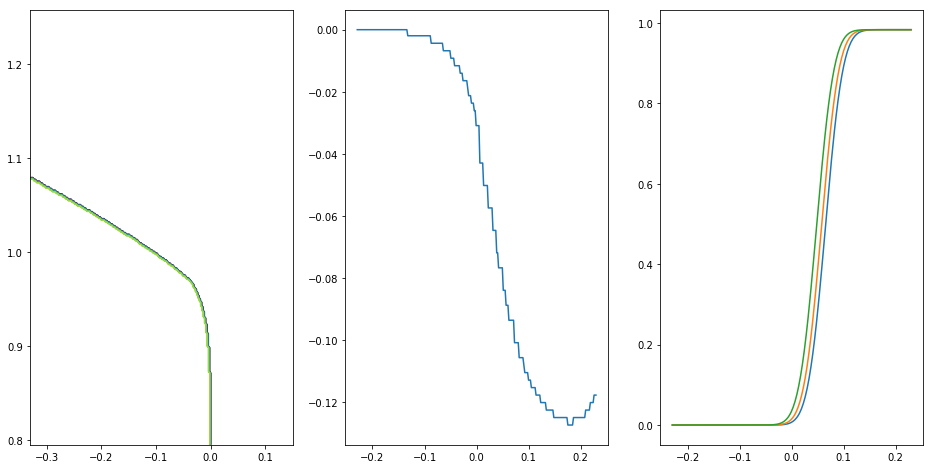

In [ ]:
default_states = V_d > V_c
B_grid_onp = onp.array(B_grid)
log_y_grid_onp = onp.array(log_y_grid)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.contour(B_grid_onp, onp.array(y_grid), default_states * 1.)

# plt.subplot(1, 3, 2)
# B_next = B_grid_onp[idx_B]
# idx = onp.argmin(onp.abs(B_grid_onp + 0.1))
# plt.plot(log_y_grid_onp, B_next[:, idx])

plt.subplot(1, 3, 3)
plt.plot(log_y_grid_onp, Q[:, 21])
plt.plot(log_y_grid_onp, Q[:, 31])
plt.plot(log_y_grid_onp, Q[:, 41]);